In [758]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import griddata
import matplotlib as mpl
from shapely.geometry import Point
%reset


Nothing done.


### Read data

In [759]:
# weather station data
raw_data = pd.read_table("./data/climate/SURF_CLI_CHN_MUL_DAY-TEM-12001-201905.TXT", header=None, sep='\s+')

In [760]:
raw_data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,50136,5258,12231,4385,2019,5,1,59,169,-49,9,9,9
1,50136,5258,12231,4385,2019,5,2,119,254,-40,9,9,9
2,50136,5258,12231,4385,2019,5,3,88,170,7,9,9,9
3,50136,5258,12231,4385,2019,5,4,40,82,-8,9,9,9
4,50136,5258,12231,4385,2019,5,5,35,131,-78,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21670,59855,1913,11029,233,2019,5,27,291,329,268,9,9,9
21671,59855,1913,11029,233,2019,5,28,281,336,251,9,9,9
21672,59855,1913,11029,233,2019,5,29,274,334,251,9,9,9
21673,59855,1913,11029,233,2019,5,30,251,338,237,9,9,9


In [761]:
# add column info
raw_data.columns = ['id', 'latitude', 'longitude', 'altitude', 'year', 'month', 'day', 'avg_temp', 'max_temp', 'min_temp', 'col1', 'col2', 'col3']

In [762]:
raw_data.head()

,id,latitude,longitude,altitude,year,month,day,avg_temp,max_temp,min_temp,col1,col2,col3
0,50136,5258,12231,4385,2019,5,1,59,169,-49,9,9,9
1,50136,5258,12231,4385,2019,5,2,119,254,-40,9,9,9
2,50136,5258,12231,4385,2019,5,3,88,170,7,9,9,9
3,50136,5258,12231,4385,2019,5,4,40,82,-8,9,9,9
4,50136,5258,12231,4385,2019,5,5,35,131,-78,9,9,9


In [763]:
raw_data.nunique()

id           699
latitude     597
longitude    646
altitude     679
year           1
month          1
day           31
avg_temp     367
max_temp     394
min_temp     386
col1           1
col2           1
col3           1
dtype: int64

### Data processing

In [764]:
# Check missing values
df = raw_data.copy()
df.isnull().sum()

id           0
latitude     0
longitude    0
altitude     0
year         0
month        0
day          0
avg_temp     0
max_temp     0
min_temp     0
col1         0
col2         0
col3         0
dtype: int64

In [765]:
# df.isnull().mean()  # 缺失值占比
# df[df.isnull().any(axis=1)]  # 查看包含缺失值的行


In [766]:
# drop rows with missing values
# df.dropna()  
# df.dropna(axis=1) 

# # df.fillna(0)  # 用 0 填充
# df.fillna(df.mean())  # 用均值填充（适用于数值型）


In [767]:
# Check duplicates
print(df.duplicated().sum())  
# df[df.duplicated()]  # show duplicated rows


6


In [768]:
df.drop_duplicates(inplace=True)


In [769]:
# filter unreasonable values
lower_bound = -700
upper_bound = 700
print(df['avg_temp'].max(), df['avg_temp'].min())

df = df[(df["avg_temp"] >= lower_bound) & (df["avg_temp"] <= upper_bound)]  # 过滤异常值
print(df['avg_temp'].max(), df['avg_temp'].min())

# 度分格式转换为十进制格式
df['latitude'] = (df['latitude'] // 100) + (df['latitude'] % 100) / 60
df['longitude'] = (df['longitude'] // 100) + (df['longitude'] % 100) / 60

# 经纬度也有错误值
# df = df[(df["latitude"] >= 10) & (df["latitude"] <= 54)]  # 10度以下基本为海域
# df = df[(df["longitude"] >= 73) & (df["longitude"] <= 136)] 

32766 -49
359 -49


In [770]:
# calculate the average temperature for each station
ave_data = (
    df.groupby(['latitude', 'longitude'])
    .agg(avg_temp=('avg_temp', 'mean'))
    .reset_index()
)

ave_data['avg_temp'] = ave_data['avg_temp']*0.1

ave_data

,latitude,longitude,avg_temp
0,2.000000,110.250000,27.909677
1,2.316667,110.300000,26.840000
2,2.533333,109.833333,26.606452
3,2.566667,114.366667,24.600000
4,2.600000,106.450000,22.129032
...,...,...,...
794,51.666667,124.383333,8.936364
795,51.666667,124.400000,10.105000
796,51.733333,126.633333,11.470968
797,52.350000,124.716667,9.790323


In [771]:
# single_data = df[(df["day"] == 1)]
# single_data 

### Interpolation

In [772]:
raw_map_data = gpd.read_file(filename="./data/json/boundary202111.json")
map_data = raw_map_data.copy()
map_data['geometry'] = map_data.buffer(0)
map_data.crs

Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [773]:
def check_point_in_map(data, map_data):
    data_copy = data.copy() 
    data_copy['geometry'] = data_copy.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # 将 data_copy 转换为 GeoDataFrame
    temp_gdf = gpd.GeoDataFrame(data_copy, geometry='geometry', crs="EPSG:4326")

    data_copy['inside_map'] = temp_gdf['geometry'].apply(lambda x: map_data.contains(x).any())

    # 过滤出在地图内的点
    data_copy = data_copy[data_copy['inside_map']]
    return data_copy


In [774]:
ave_data = check_point_in_map(ave_data, map_data)

(3.39716187, 53.563269)

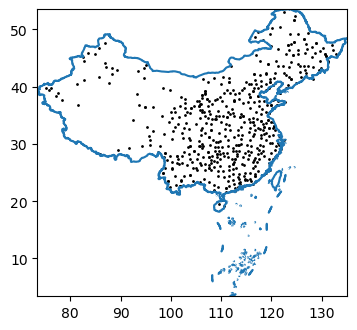

In [775]:
fig, ax = plt.subplots(figsize=(4, 6))

ax.scatter(ave_data['longitude'], ave_data['latitude'], s=1, c='black')
map_data.boundary.plot(ax=ax)
ax.set_xlim(map_data.bounds.minx[0], map_data.bounds.maxx[0])
ax.set_ylim(map_data.bounds.miny[0], map_data.bounds.maxy[0])

In [776]:
# interpolation
def gridded_data(data, map, method='cubic'):

    x_min, y_min, x_max, y_max = map.total_bounds

    # 生成网格点
    longitude_x = np.arange(x_min, x_max, 0.1)  # 每 0.1 度一个点
    latitude_y = np.arange(y_min, y_max, 0.1)


    # 生成网格坐标
    grid_x, grid_y = np.meshgrid(longitude_x, latitude_y)

    # 进行插值
    predict = griddata(
        points=(data['longitude'], data['latitude']),
        values=data['avg_temp'],
        xi=(grid_x, grid_y),
        method=method  # 也可以尝试 'linear' 或 'nearest' cubic
    )
    return predict

In [777]:
predict = gridded_data(ave_data, map_data, method='linear')

In [778]:
# total area
# fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# map_data.boundary.plot(ax=ax, color='blue')

# vmin, vmax = np.nanmin(predict), np.nanmax(predict)
# cmap = plt.cm.jet 
# norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 

# minx, miny, maxx, maxy = map_data.total_bounds
# img = ax.imshow(predict, origin='lower', extent=(minx, maxx, miny, maxy), cmap=cmap, norm=norm)

# ax.scatter(ave_data['longitude'], ave_data['latitude'], c='black', s=2)

# for index in range(ave_data.shape[0]):
#     ax.text(
#         ave_data.iloc[index]['longitude'], ave_data.iloc[index]['latitude'],
#         np.around(ave_data.iloc[index]['avg_temp'], 2),
#         color='black', fontsize=8
#     )

# cbar = fig.colorbar(img, ax=ax, orientation="vertical", shrink=0.8) 
# cbar.set_label("Temperature (°C)", fontsize=12)

# plt.tight_layout()
# plt.show()
# # plt.smapfig("result012901.png")

Local region

In [779]:
raw_full_map = gpd.read_file(filename="./data/json/100000_full.json")


Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


In [780]:

full_map_data = raw_full_map.copy()
full_map_data['geometry'] = full_map_data.buffer(0)
full_map_data.loc[~full_map_data.is_valid]
# f_minx, f_miny, f_maxx, f_maxy = full_map_data.total_bounds

,adcode,name,adchar,childrenNum,level,parent,subFeatureIndex,geometry


In [781]:
province_name = '山西省'
single_province = full_map_data[full_map_data['name'] == province_name]
single_province

,adcode,name,adchar,childrenNum,level,parent,subFeatureIndex,geometry
3,140000,山西省,None,11.0,province,"{ ""adcode"": 100000 }",3.0,"POLYGON ((110.37926 34.60061, 110.29549 34.610..."


In [782]:
# # mask based on province
# ave_mask = ave_data.copy()
# ave_mask['inside_prov'] = ave_mask.apply(lambda row: single_province['geometry'].contains(Point(row['longitude'], row['latitude'])), axis=1)

# mask_values = ave_mask[ave_mask['inside_prov']==True]

# mask_values

In [783]:
mask_values = ave_data.copy()
mask_values = check_point_in_map(mask_values, single_province)

# mask_values

In [784]:
interp_method = 'linear'

predict_masked = gridded_data(mask_values, single_province, method=interp_method)

In [785]:

def plot_temperature_map(predict_matrix, mask_values, single_province, model_name='Random Forest'):

    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

    # 获取温度矩阵的最小值和最大值来设置颜色范围
    vmin, vmax = np.nanmin(predict_matrix), np.nanmax(predict_matrix)
    cmap = plt.cm.jet
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    single_province.boundary.plot(ax=ax, color='white')
    
    min_x, min_y, max_x, max_y = single_province.total_bounds
    if model_name != 'Random Forest' and model_name != 'Support Vector Machine':
        min_x, min_y, max_x, max_y = full_map_data.total_bounds
    # 注意赋值方式会改变全局变量值
    # print(min_x, min_y, max_x, max_y)

    img = ax.imshow(predict_matrix, origin='lower', extent=(min_x, max_x, min_y, max_y), cmap=cmap, norm=norm)
    
    ax.scatter(mask_values['longitude'], mask_values['latitude'], c='black', s=6)
    
   
    for index in range(mask_values.shape[0]):
        ax.text(mask_values.iloc[index]['longitude'], mask_values.iloc[index]['latitude'],
                np.around(mask_values.iloc[index]['avg_temp'], 2), color='black')

    cbar = fig.colorbar(img, ax=ax, orientation="vertical", shrink=0.8)
    cbar.set_label("Temperature (°C)", fontsize=12)

    x_min, y_min, x_max, y_max = single_province.total_bounds
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    plt.title(f"Interpolate with {model_name}", fontsize=16)

    plt.tight_layout()
    plt.show()
    return



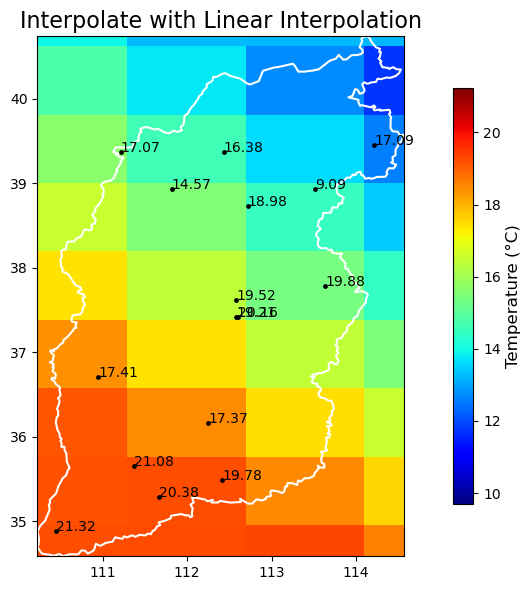

In [786]:
plot_temperature_map(predict_masked, mask_values, single_province, model_name='Linear Interpolation')

Random forest interpolation

In [787]:
from sklearn.ensemble import RandomForestRegressor
x_train = mask_values[['latitude', 'longitude']]
y_train = mask_values[['avg_temp']]

rf_model = RandomForestRegressor() # n_estimators=2000,min_samples_split=10
rf_model.fit(x_train, y_train.squeeze())

RandomForestRegressor()

In [788]:
# build the grid
minx, miny, maxx, maxy = single_province.total_bounds

longitude_x = np.arange(minx, maxx, 0.1)  # 每隔 0.1 度
latitude_y = np.arange(miny, maxy, 0.1)

predict_Latitude, predict_longitude = np.meshgrid(latitude_y, longitude_x)
predict_df = pd.DataFrame({'latitude':predict_Latitude.flatten(),
                           'longitude':predict_longitude.flatten()})

# interpolate 
predict_value = rf_model.predict(predict_df)
predict_matrix = predict_value.reshape(predict_Latitude.shape)


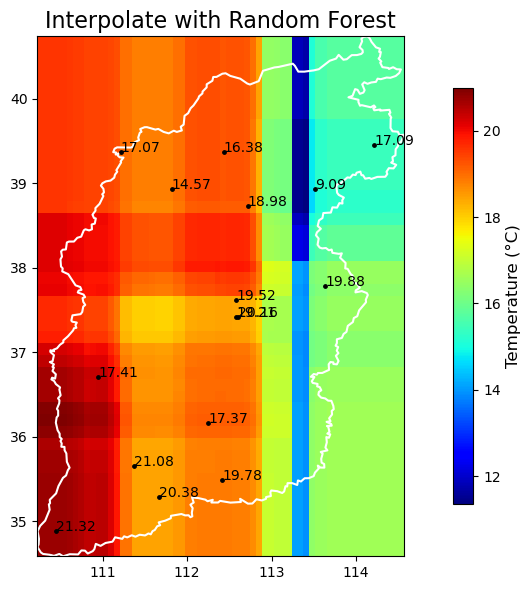

In [789]:
plot_temperature_map(predict_matrix, mask_values, single_province, model_name='Random Forest')


SVM interpolation

In [790]:
from sklearn.svm import SVR
x_train = mask_values[['latitude', 'longitude']]
y_train = mask_values['avg_temp']

rf_model = SVR(C = 2, kernel='linear') #n_estimators=2000,min_samples_split=20
rf_model.fit(x_train, y_train)

SVR(C=2, kernel='linear')

In [791]:
# build the grid
predict_Latitude, predict_longitude = np.meshgrid(latitude_y, longitude_x)
predict_df = pd.DataFrame({'latitude':predict_Latitude.flatten(),
                           'longitude':predict_longitude.flatten()})

# interpolate
predict_value = rf_model.predict(predict_df)
predict_matrix = predict_value.reshape(predict_Latitude.shape)


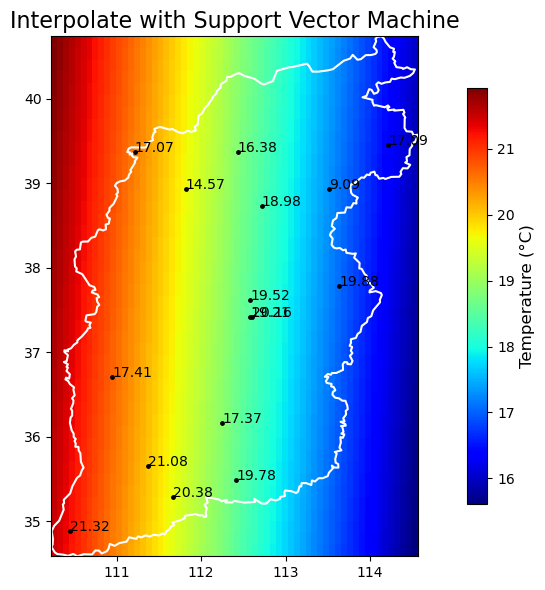

In [792]:
plot_temperature_map(predict_matrix, mask_values, single_province, model_name='Support Vector Machine')
